In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install nptdms

## WPT+FFT 적용

In [14]:
import os
import numpy as np
import pandas as pd
import pywt
from scipy.fft import rfft
from nptdms import TdmsFile

In [15]:
# 1. TDMS 파일에서 진동 및 운전 데이터 불러오기
def load_tdms_file(file_path):
    tdms_file = TdmsFile.read(file_path)
    group_name_vibration = tdms_file.groups()[0].name
    group_name_operation = tdms_file.groups()[1].name

    vib_channels = tdms_file[group_name_vibration].channels()
    vib_data = {ch.name.strip(): ch.data for ch in vib_channels}

    operation_channels = tdms_file[group_name_operation].channels()
    operation_data = {ch.name.strip(): ch.data for ch in operation_channels}

    return vib_data, operation_data

In [16]:
# 2. 슬라이딩 윈도우 분할 (window_size 샘플, overlap 비율)
def sliding_window(data, window_size=25600, overlap=0.5):
    step = int(window_size * (1 - overlap))
    return np.array([
        data[start:start + window_size]
        for start in range(0, len(data) - window_size + 1, step)
    ])  # (윈도우 수, window_size, 채널 수)

# 3. 1차원 신호에 대해 WPT+FFT top_k 에너지 특징 추출
def extract_wpt_fft_features(signal, wavelet='db4', level=3, top_k=10):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = [node.path for node in wp.get_level(level, 'freq')]
    features = []
    for node in nodes:
        coeffs = wp[node].data
        fft_vals = np.abs(rfft(coeffs))
        top_features = np.sort(fft_vals)[-top_k:]
        features.extend(top_features)
    return np.array(features)  # (노드 수 × top_k, )

In [17]:
# 4. TDMS 파일 경로로부터 진동 데이터 읽어, 윈도우별 WPT+FFT 특징 추출 함수
def extract_vibration_array_with_features(file_path, window_size=25600, overlap=0.5, wavelet='db4', level=3, top_k=10):
    vib_data, _ = load_tdms_file(file_path)
    channels = ["CH1", "CH2", "CH3", "CH4"]
    vib_arrays = [vib_data[ch] for ch in channels if ch in vib_data]
    vib_matrix = np.vstack(vib_arrays).T  # (샘플 수, 4)

    windows = sliding_window(vib_matrix, window_size=window_size, overlap=overlap)  # (윈도우 수, window_size, 4)

    all_features = []
    for window in windows:
        window_features = []
        for ch_idx in range(window.shape[1]):
            signal = window[:, ch_idx]
            feat = extract_wpt_fft_features(signal, wavelet=wavelet, level=level, top_k=top_k)
            window_features.extend(feat)
        all_features.append(window_features)

    return np.array(all_features)  # (윈도우 수, 채널 수 * 특징 수)

결과 확인

In [18]:
def process_train1_folder(folder_path):
    tdms_files = [f for f in os.listdir(folder_path) if f.endswith(".tdms")]
    tdms_files.sort()

    results = {}
    for tdms_file in tdms_files:
        file_path = os.path.join(folder_path, tdms_file)
        features = extract_vibration_array_with_features(file_path)
        results[tdms_file] = features

    return results

train1_folder = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set/Train1"

# 실행
features_dict = process_train1_folder(train1_folder)

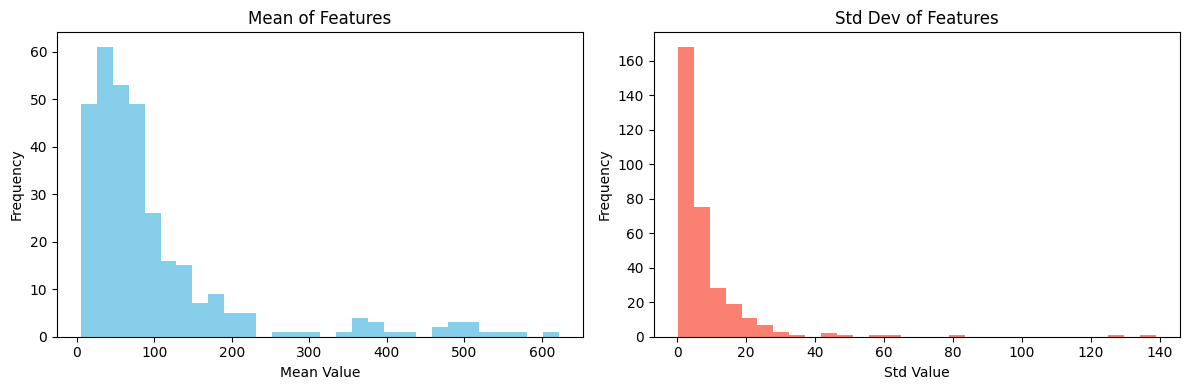

<ipython-input-23-63189e65b0a0>:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=30, palette='viridis')


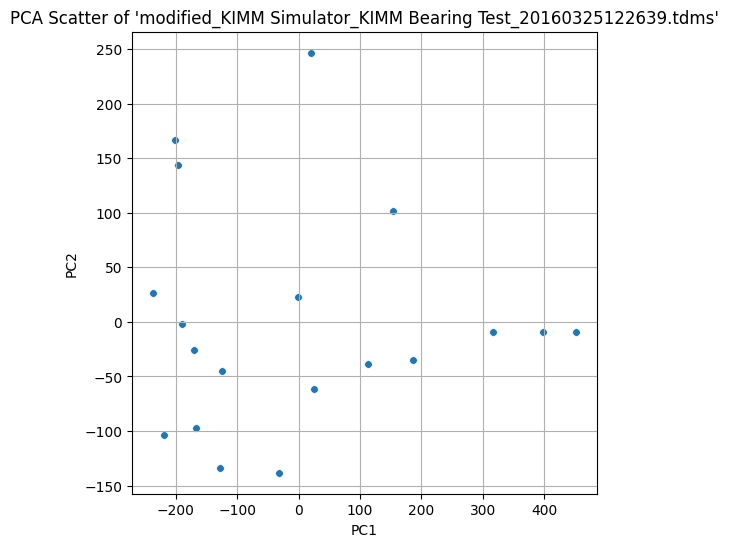

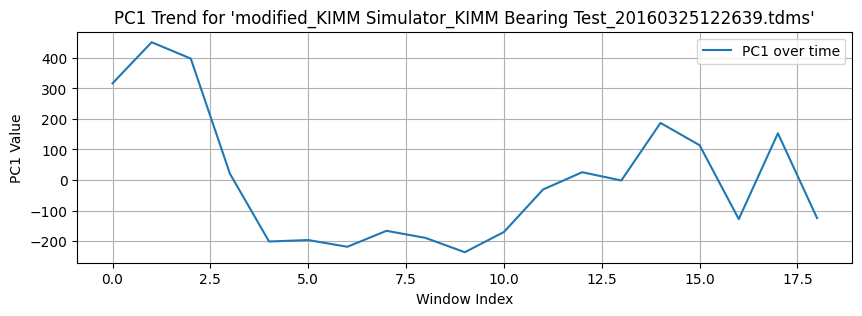

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def visualize_feature_summary(features_dict, sample_file=None):
    if sample_file is None:
        sample_file = list(features_dict.keys())[0]  # 아무 파일이나 하나 선택

    features = features_dict[sample_file]  # (윈도우 수, 전체 특징 수)

    # 1. 특징 평균 및 표준편차 히스토그램
    mean_vals = np.mean(features, axis=0)
    std_vals = np.std(features, axis=0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(mean_vals, bins=30, color='skyblue')
    plt.title("Mean of Features")
    plt.xlabel("Mean Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(std_vals, bins=30, color='salmon')
    plt.title("Std Dev of Features")
    plt.xlabel("Std Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 2. PCA로 2D 시각화
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=30, palette='viridis')
    plt.title(f"PCA Scatter of '{sample_file}'")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

    # 3. 시간 흐름에 따른 첫 번째 주성분 변화
    plt.figure(figsize=(10, 3))
    plt.plot(pca_result[:, 0], label="PC1 over time")
    plt.title(f"PC1 Trend for '{sample_file}'")
    plt.xlabel("Window Index")
    plt.ylabel("PC1 Value")
    plt.legend()
    plt.grid(True)
    plt.show()
visualize_feature_summary(features_dict)
